In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append('..')
from cann import CANN1D

seed = 123


/home/zilong/anaconda3/envs/hippocampalsequence/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1, simulate theta sweep at two different adaptation strength

In [2]:
#set default ramndom seed for reproducibility
np.random.seed(seed)
#set backend to cpu
bm.set_platform('cpu')
#build and run the network
sweep_cann_1 = CANN1D(tau=1, tau_v=48., num=128, mbar=5.5, A=0.01)

v_ext = sweep_cann_1.a / 144 * 0.55   #animal speed
sweep_dur = 2.5*np.pi / v_ext              #duration of simulation
dt = bm.get_dt()                     #simulation time step                         
steps = int(sweep_dur / dt)                #steps of simulation

position = np.zeros(steps)
position[0] = -np.pi/3               #initial position
#generate position array
for i in range(steps)[1:]:
    position[i] = position[i - 1] + v_ext * dt
    if position[i] > np.pi:          #periodic boundary condition
        position[i] -= 2 * np.pi

position = position.reshape((-1, 1)) #reshape to (steps, 1) array to fit the input shape

noise = 0.001*np.random.randn(steps,sweep_cann_1.num) #add independent noise to the input with level 0.01

#generate series of external input bump
Iext = sweep_cann_1.get_stimulus_by_pos(position) + noise

#simulate the network
sweep_runner_1 = bp.DSRunner(sweep_cann_1,
                     inputs=('input', Iext, 'iter'),
                     monitors=['u', 'v', 'r','center','centerI'])
sweep_runner_1.run(sweep_dur)


#############################################################################################################
#set default ramndom seed for reproducibility
np.random.seed(seed)
#set backend to cpu
bm.set_platform('cpu')
#build and run the network
sweep_cann_2 = CANN1D(tau=1, tau_v=48, num=128, mbar=9.)

#simulate the network
sweep_runner_2 = bp.DSRunner(sweep_cann_2,
                     inputs=('input', Iext, 'iter'),
                     monitors=['u', 'v', 'r','center','centerI'])
sweep_runner_2.run(sweep_dur)

Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 92614.11it/s] 


### 2, simulate replay at two different adaptation strength

In [3]:
dt = bm.get_dt()
replay_dur = 200         #simulate 200 ms, roughly the length of a SWR
init_dur = 50 #initial 10 ms to let the network settle

#build and run the network
#set default ramndom seed for reproducibility
np.random.seed(seed)
#set backend to cpu
bm.set_platform('cpu')

replay_cann_1 = CANN1D(tau=1., tau_v=48., num=128, mbar=1.5)
replay_cann_1.reset_state()
Iext, length = bp.inputs.section_input(
    values=[replay_cann_1.get_stimulus_by_pos(-3/4*np.pi), 0.], #initial position of the bump
    durations=[init_dur, replay_dur],
    return_length=True
)
noise = 0.02* np.random.randn(len(Iext), replay_cann_1.num) #add independent noise to the input with level 0.02
Iext = Iext + noise
Iext = bm.as_numpy(Iext)

#run the network
replay_runner_1 = bp.DSRunner(replay_cann_1,
                     inputs=('input', Iext, 'iter'),
                     monitors=['r'])

replay_runner_1.run(length)

#############################################################################################################
#set default ramndom seed for reproducibility
np.random.seed(seed)
#set backend to cpu
bm.set_platform('cpu')
#build and run the network
replay_cann_2 = CANN1D(tau=1., tau_v=48., num=128, mbar=3.5)
replay_cann_2.reset_state()
Iext, length = bp.inputs.section_input(
    values=[replay_cann_2.get_stimulus_by_pos(-3/4*np.pi), 0.], #initial position of the bump
    durations=[init_dur, replay_dur],
    return_length=True
)
noise = 0.02* np.random.randn(len(Iext), replay_cann_2.num) #add independent noise to the input with level 0.02
Iext = Iext + noise
Iext = bm.as_numpy(Iext)

#run the network
replay_runner_2 = bp.DSRunner(replay_cann_2,
                     inputs=('input', Iext, 'iter'),
                     monitors=['r'])

replay_runner_2.run(length)


Predict 2500 steps: :   0%|          | 0/2500 [00:00<?, ?it/s]

Predict 2500 steps: : 100%|██████████| 2500/2500 [00:00<00:00, 20676.22it/s]


### 2 visualize

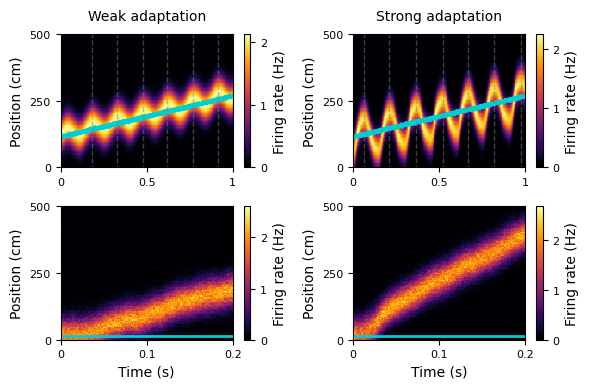

In [12]:
#make two subplots
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
#set font size
labelsize = 10
ticksize = 8

########
#plot 1#
########

#visualize bump sweeps for 1 second. Cut the middle 1 second to avoid transient at the boundary
time = np.linspace(0, sweep_dur, steps)    #time array
time_start = int(1.9*bm.pi / v_ext/ dt)
time_end = int(2.9*bm.pi / v_ext/ dt)
time_slice=time[time_start:time_end]
#subtract time 0 from time_slice
time_slice = time_slice - time_slice[0]

pos = np.linspace(-np.pi,np.pi,sweep_cann_1.num+1)[0:-1]
fr = sweep_runner_1.mon.r.T[:,time_start:time_end]
cI = sweep_runner_1.mon.centerI[time_start:time_end]

##Theta oscillations
relative_pos = sweep_runner_1.mon.center[time_start:time_end] - sweep_runner_1.mon.centerI[time_start:time_end]
relative_pos = bm.where(relative_pos > np.pi, relative_pos - 2*np.pi,  relative_pos)
relative_pos = bm.where(relative_pos < -np.pi, relative_pos + 2*np.pi,  relative_pos)
relative_pos = np.squeeze(relative_pos)
Peaks,_ = scipy.signal.find_peaks(relative_pos, width=300)

c = axs[0,0].pcolormesh(time_slice[0:-1:50], pos, fr[:,0:-1:50]*1e3, cmap='inferno')
#add colorbar to axs[0]
clb = plt.colorbar(c, ax=axs[0,0], location='right', ticks=[0, 1, 2])
clb.set_label('Firing rate (Hz)', fontsize=labelsize)
clb.ax.tick_params(labelsize=ticksize)
#add animal position to the plot
axs[0,0].plot(time_slice, cI, color='darkturquoise', linewidth=1, alpha=1.0)

#add separate lines to theta sweeps
for peaks in Peaks:
    axs[0,0].plot([time_slice[peaks], time_slice[peaks]],[-np.pi,np.pi],color='grey',linewidth=1, linestyle='--', alpha=0.5)

#set xlim and ylim
axs[0,0].set_xlim([0, 1e3])
axs[0,0].set_ylim([-2.5,2.5])
#set x and y labels
#axs[0,0].set_xlabel('Time (s)', fontsize=labelsize)
axs[0,0].set_ylabel('Position (cm)', fontsize=labelsize)
# set x and y ticks
xticks = np.linspace(0, 1e3, 3)
yticks = np.linspace(-2.5,2.5,3)
#set tick labels
xticklabels = [0, 0.5, 1]
yticklabels = [0, int(2.5*100), int(5*100)]

axs[0,0].set_xticks(xticks)
axs[0,0].set_yticks(yticks)
axs[0,0].set_xticklabels(xticklabels, fontsize=ticksize)
axs[0,0].set_yticklabels(yticklabels, fontsize=ticksize)

axs[0,0].tick_params(axis='x', labelsize=ticksize)
axs[0,0].tick_params(axis='y', labelsize=ticksize)

#add title
axs[0,0].set_title('Weak adaptation', fontsize=labelsize, pad=10)

########
#plot 2#
########

#visualize bump sweeps for 1 second. Cut the middle 1 second to avoid transient at the boundary
time = np.linspace(0, sweep_dur, steps)    #time array
time_start = int(1.9*bm.pi / v_ext/ dt)
time_end = int(2.9*bm.pi / v_ext/ dt)
time_slice=time[time_start:time_end]
#subtract time 0 from time_slice
time_slice = time_slice - time_slice[0]

pos = np.linspace(-np.pi,np.pi,sweep_cann_2.num+1)[0:-1]
fr = sweep_runner_2.mon.r.T[:,time_start:time_end]
cI = sweep_runner_2.mon.centerI[time_start:time_end]

##Theta oscillations
relative_pos = sweep_runner_2.mon.center[time_start:time_end] - sweep_runner_2.mon.centerI[time_start:time_end]
relative_pos = bm.where(relative_pos > np.pi, relative_pos - 2*np.pi,  relative_pos)
relative_pos = bm.where(relative_pos < -np.pi, relative_pos + 2*np.pi,  relative_pos)
relative_pos = np.squeeze(relative_pos)
Peaks,_ = scipy.signal.find_peaks(relative_pos, width=300)

c = axs[0,1].pcolormesh(time_slice[0:-1:50], pos, fr[:,0:-1:50]*1e3, cmap='inferno')
#add colorbar to axs[0]
clb = plt.colorbar(c, ax=axs[0,1], location='right', ticks=[0, 1, 2])
clb.set_label('Firing rate (Hz)', fontsize=labelsize)
clb.ax.tick_params(labelsize=ticksize)
#add animal position to the plot
axs[0,1].plot(time_slice, cI, color='darkturquoise', linewidth=1, alpha=1.0)

#add separate lines to theta sweeps
for peaks in Peaks:
    axs[0,1].plot([time_slice[peaks], time_slice[peaks]],[-np.pi,np.pi],color='grey',linewidth=1, linestyle='--', alpha=0.5)

#set xlim and ylim
axs[0,1].set_xlim([0, 1e3])
axs[0,1].set_ylim([-2.5,2.5])
#set x and y labels
#axs[0,1].set_xlabel('Time (s)', fontsize=labelsize)
axs[0,1].set_ylabel('Position (cm)', fontsize=labelsize)
# set x and y ticks
xticks = np.linspace(0, 1e3, 3)
yticks = np.linspace(-2.5,2.5,3)
#set tick labels
xticklabels = [0, 0.5, 1]
yticklabels = [0, int(2.5*100), int(5*100)]

axs[0,1].set_xticks(xticks)
axs[0,1].set_yticks(yticks)
axs[0,1].set_xticklabels(xticklabels, fontsize=ticksize)
axs[0,1].set_yticklabels(yticklabels, fontsize=ticksize)

axs[0,1].tick_params(axis='x', labelsize=ticksize)
axs[0,1].tick_params(axis='y', labelsize=ticksize)

#add title 
axs[0,1].set_title('Strong adaptation', fontsize=labelsize, pad=10)

########
#plot 3#
########

fr = replay_runner_1.mon.r.T
pos = np.linspace(-np.pi,np.pi,replay_cann_1.num)
replay_steps = int(replay_dur / dt)
time = np.linspace(init_dur, replay_dur+init_dur, replay_steps)
init_index = int(init_dur/dt)
c = axs[1,0].pcolormesh(time[::5]-time[0], pos, fr[:,init_index:-1:5]*1e3, cmap='inferno')
axs[1,0].set_xlim((0,200))
clb = plt.colorbar(c, ax=axs[1,0], location='right', ticks=[0, 1, 2])
clb.set_label('Firing rate (Hz)', fontsize=labelsize)
clb.ax.tick_params(labelsize=ticksize)

#add an horizontal line to indicate the position of the bump at y=-3/4*np.pi
axs[1,0].plot([0,200],[-3/4*np.pi,-3/4*np.pi],color='darkturquoise',linewidth=2, alpha=1)

#set xlim and ylim
axs[1,0].set_xlim([0, 200])
axs[1,0].set_ylim([-2.5,2.5])
#set x and y labels
axs[1,0].set_xlabel('Time (s)', fontsize=labelsize)
axs[1,0].set_ylabel('Position (cm)', fontsize=labelsize)

# set x and y ticks
xticks = np.linspace(0, 200, 3)
yticks = np.linspace(-2.5,2.5,3)
#set tick labels
xticklabels = [0, 0.1, 0.2]
yticklabels = [0, int(2.5*100), int(5*100)]

axs[1,0].set_xticks(xticks)
axs[1,0].set_yticks(yticks)
axs[1,0].set_xticklabels(xticklabels, fontsize=ticksize)
axs[1,0].set_yticklabels(yticklabels, fontsize=ticksize)

axs[1,0].tick_params(axis='x', labelsize=ticksize)
axs[1,0].tick_params(axis='y', labelsize=ticksize)

########
#plot 4#
########

fr = replay_runner_2.mon.r.T
pos = np.linspace(-np.pi,np.pi,replay_cann_2.num)
replay_steps = int(replay_dur / dt)
time = np.linspace(init_dur, replay_dur+init_dur, replay_steps)
init_index = int(init_dur/dt)

c = axs[1,1].pcolormesh(time[::5]-time[0], pos, fr[:,init_index:-1:5]*1e3, cmap='inferno')
axs[1,1].set_xlim((0,200))
clb = plt.colorbar(c, ax=axs[1,1], location='right', ticks=[0, 1, 2])
clb.set_label('Firing rate (Hz)', fontsize=labelsize)
clb.ax.tick_params(labelsize=ticksize)
   
#add an horizontal line to indicate the position of the bump at y=-3/4*np.pi 
axs[1,1].plot([0,200],[-3/4*np.pi,-3/4*np.pi],color='darkturquoise',linewidth=2, alpha=1)
    
#set xlim and ylim
axs[1,1].set_xlim([0, 200])
axs[1,1].set_ylim([-2.5,2.5])
#set x and y labels
axs[1,1].set_xlabel('Time (s)', fontsize=labelsize)
axs[1,1].set_ylabel('Position (cm)', fontsize=labelsize)

# set x and y ticks
xticks = np.linspace(0, 200, 3)
yticks = np.linspace(-2.5,2.5,3)
#set tick labels
xticklabels = [0, 0.1, 0.2]
yticklabels = [0, int(2.5*100), int(5*100)]

axs[1,1].set_xticks(xticks)
axs[1,1].set_yticks(yticks)
axs[1,1].set_xticklabels(xticklabels, fontsize=ticksize)
axs[1,1].set_yticklabels(yticklabels, fontsize=ticksize)

axs[1,1].tick_params(axis='x', labelsize=ticksize)
axs[1,1].tick_params(axis='y', labelsize=ticksize)


plt.tight_layout()

#save
plt.savefig('./Fig3_sweep_replay.pdf', bbox_inches='tight', dpi=300)
